In [7]:
import subprocess
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from typing import List
import matplotlib.pyplot as plt
%matplotlib inline  

ini_format = """
[General]
network = Scheduler
**.serverCount = {}
**.server[*].serviceTime = {}s
**.source.interArrivalTime = exponential({}s)  
**.source.numJobs = {}
**.registrar.acceptenceRate = 0.9
repeat = 1000
"""

def ini_gen(service_time=1, students=700, inter_arrival_time=0.5, server_count=1):
    contents = ini_format.format(server_count, service_time, inter_arrival_time, students)
    with open("custom.ini", "w") as f:
        f.write(contents)
        
def run_omnetpp():
    subprocess.call("rm results/totaled.csv", shell=True)
    subprocess.call("opp_runall -j24 -b41 ./FinalProjectTry2 -m -u Cmdenv -n .:../queueinglib -l ../queueinglib/queueinglib custom.ini -c General", shell=True)
    subprocess.call("cd results && scavetool x *.sca -o totaled.csv", shell=True)
    a = pd.read_csv("results/totaled.csv")
    return a.pivot_table(columns="name", values="value", index="run")

    
def process_results(dataset):
    def process_column(param, nice_name): 
        values = dataset[param].dropna() 
        return {f"{nice_name} Mean": values.mean(), f"{nice_name} SE": values.sem(),
                f"{nice_name} Std. Dev": values.std(), f"{nice_name} %Err": 100 * values.sem() / values.mean()}
        
    results = process_column("lifeTime:max", "Max Registration Time")
    results.update(process_column("lifeTime:mean", "Mean Registration Time"))
    results.update(process_column("queueLength:max","Max Queue Length"))
    return results

def run_simulation(service_time=1, students=700, inter_arrival_time=0.5, server_count=1):
    ini_gen(service_time, students, inter_arrival_time, server_count) 
    a = run_omnetpp()
    results = process_results(a)
    results["Service Time"] = service_time
    results["Students"] = students
    results["Inter-arrival Time"] = inter_arrival_time
    results["Server Count"] = server_count
    return results 

def fix_order(columns):
    columns = list(columns)
    for c in ["Service Time", "Students", "Inter-arrival Time", "Server Count"]:
        columns.remove(c)
        columns.insert(0, c)
    return columns

def pretty_format(data):
    return pd.DataFrame(data, columns=fix_order(data[0].keys()))

def save_plot(name):
    plt.savefig(f"images/{name}.png", dpi=300)

In [8]:
run_simulation(1, 100)

{'Max Registration Time Mean': 83.55854493959164,
 'Max Registration Time SE': 0.29442697185679984,
 'Max Registration Time Std. Dev': 9.310598356537822,
 'Max Registration Time %Err': 0.3523600992210369,
 'Mean Registration Time Mean': 31.66950963124321,
 'Mean Registration Time SE': 0.106778243995269,
 'Mean Registration Time Std. Dev': 3.3766245557824757,
 'Mean Registration Time %Err': 0.33716418485345945,
 'Max Queue Length Mean': 55.267,
 'Max Queue Length SE': 0.1497201627274267,
 'Max Queue Length Std. Dev': 4.734567258697159,
 'Max Queue Length %Err': 0.2709033649871111,
 'Service Time': 1,
 'Students': 100,
 'Inter-arrival Time': 0.5,
 'Server Count': 1}

In [9]:
student_trials = pretty_format([run_simulation(students=s) for s in tqdm_notebook(np.linspace(700, 1500, 10, dtype=int))])
service_time_trials = pretty_format([run_simulation(service_time=s) for s in tqdm_notebook(np.linspace(0.5, 10, 10))])
iit = pretty_format([run_simulation(inter_arrival_time=s) for s in tqdm_notebook(np.linspace(0, 10, 20))]) 
server_trials = pretty_format([run_simulation(server_count=s) for s in tqdm_notebook(np.linspace(1, 10, 10, dtype=int))])

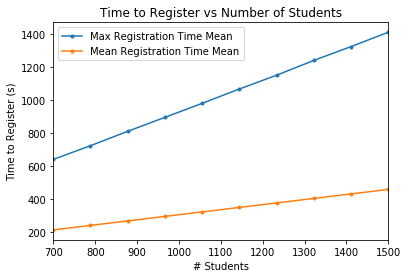

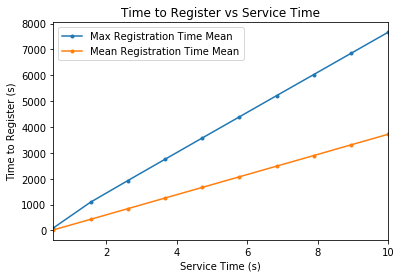

In [29]:
def plot_values(frame, x_col, y_cols, style=".-"):
    frame[[x_col] + y_cols].plot(x=x_col, style=style)

plot_values(student_trials, "Students", ["Max Registration Time Mean", "Mean Registration Time Mean"])
plt.xlabel("# Students")
plt.ylabel("Time to Register (s)")
plt.title("Time to Register vs Number of Students")
save_plot("Time to Register vs Number of Students")

plot_values(service_time_trials, "Service Time", ["Max Registration Time Mean", "Mean Registration Time Mean"])
plt.xlabel("Service Time (s)")
plt.ylabel("Time to Register (s)")
plt.title("Time to Register vs Service Time")
save_plot("Time to Register vs Service Time")



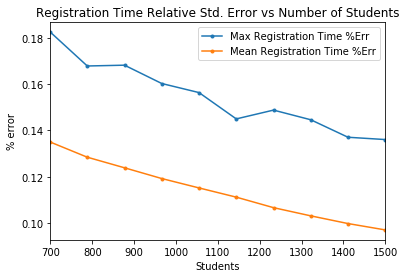

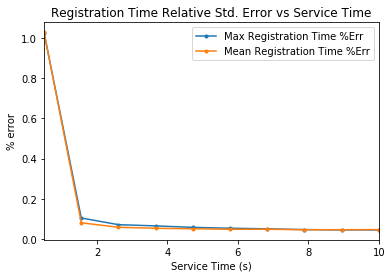

In [18]:
plot_values(student_trials, "Students", ["Max Registration Time %Err", "Mean Registration Time %Err"])
plt.ylabel("% error")
plt.title("Registration Time Relative Std. Error vs Number of Students")
save_plot("Registration Time Relative Std. Error vs Number of Students")

plot_values(service_time_trials, "Service Time", ["Max Registration Time %Err", "Mean Registration Time %Err"])
plt.xlabel("Service Time (s)")
plt.ylabel("% error")
plt.title("Registration Time Relative Std. Error vs Service Time")
save_plot("Registration Time Relative Std. Error vs Service Time")

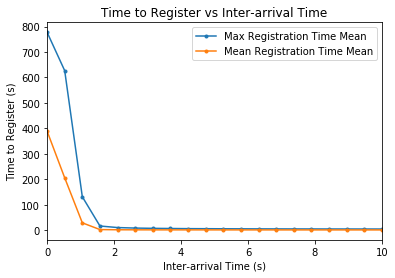

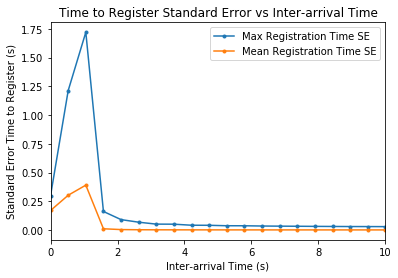

In [19]:
plot_values(iit, "Inter-arrival Time", ["Max Registration Time Mean", "Mean Registration Time Mean"])
plt.xlabel("Inter-arrival Time (s)")
plt.ylabel("Time to Register (s)")
plt.title("Time to Register vs Inter-arrival Time")
save_plot("Time to Register vs Inter-arrival Time")

plot_values(iit, "Inter-arrival Time", ["Max Registration Time SE", "Mean Registration Time SE"])
plt.xlabel("Inter-arrival Time (s)")
plt.ylabel("Standard Error Time to Register (s)")
plt.title("Time to Register Standard Error vs Inter-arrival Time")
save_plot("Time to Register Standard Error vs Inter-arrival Time")

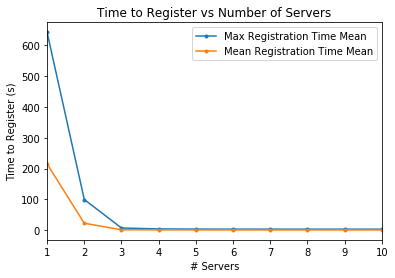

In [20]:
plot_values(server_trials, "Server Count", ["Max Registration Time Mean", "Mean Registration Time Mean"])
plt.xlabel("# Servers")
plt.ylabel("Time to Register (s)")
plt.title("Time to Register vs Number of Servers")
save_plot("Time to Register vs Number of Servers")


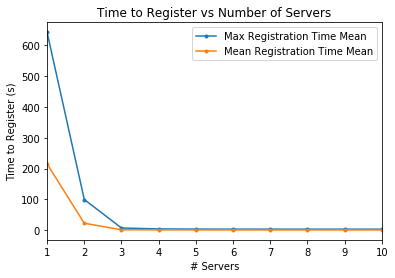

In [21]:
plot_values(server_trials, "Server Count", ["Max Registration Time Mean", "Mean Registration Time Mean"])
plt.xlabel("# Servers")
plt.ylabel("Time to Register (s)")
plt.title("Time to Register vs Number of Servers")
save_plot("Time to Register vs Number of Servers")


In [40]:
def lin_regres(frame, x, y): 
    fit = np.polyfit(frame[[x]].values.ravel(), frame[[y]].values.ravel(), 1) 
    print(f"{x}\t{round(fit[0], 2)}")
#     return fit[0] # Returns the slope

lin_regres(iit, "Inter-arrival Time", "Mean Registration Time Mean")


Inter-arrival Time	-16.15


In [41]:
lin_regres(iit, "Inter-arrival Time", "Mean Registration Time Mean")
lin_regres(server_trials, "Server Count", "Mean Registration Time Mean")
lin_regres(student_trials, "Students", "Mean Registration Time Mean")
lin_regres(service_time_trials, "Service Time", "Mean Registration Time Mean")

Inter-arrival Time	-16.15
Server Count	-12.61
Students	0.31
Service Time	389.3


In [15]:
student_trials.round(2)

,Server Count,Inter-arrival Time,Students,Service Time,Max Registration Time Mean,Max Registration Time SE,Max Registration Time Std. Dev,Max Registration Time %Err,Mean Registration Time Mean,Mean Registration Time SE,Mean Registration Time Std. Dev,Mean Registration Time %Err,Max Queue Length Mean,Max Queue Length SE,Max Queue Length Std. Dev,Max Queue Length %Err
0,1,0.5,700,1,642.19,1.17,37.05,0.18,215.23,0.29,9.19,0.13,385.68,0.42,13.25,0.11
1,1,0.5,788,1,724.10,1.22,38.44,0.17,242.25,0.31,9.84,0.13,434.28,0.45,14.38,0.10
2,1,0.5,877,1,811.31,1.36,43.16,0.17,269.57,0.33,10.56,0.12,483.38,0.49,15.36,0.10
3,1,0.5,966,1,895.77,1.44,45.41,0.16,296.82,0.35,11.19,0.12,532.44,0.51,16.16,0.10
4,1,0.5,1055,1,980.57,1.53,48.49,0.16,324.06,0.37,11.80,0.12,581.30,0.53,16.91,0.09
5,1,0.5,1144,1,1067.46,1.55,48.95,0.14,351.22,0.39,12.35,0.11,630.19,0.55,17.52,0.09
6,1,0.5,1233,1,1150.73,1.71,54.15,0.15,378.50,0.40,12.76,0.11,679.30,0.57,17.99,0.08
7,1,0.5,1322,1,1240.46,1.79,56.73,0.14,405.74,0.42,13.23,0.10,728.24,0.59,18.53,0.08
8,1,0.5,1411,1,1323.99,1.81,57.39,0.14,433.01,0.43,13.66,0.10,777.37,0.61,19.26,0.08
9,1,0.5,1500,1,1410.93,1.92,60.71,0.14,460.15,0.45,14.12,0.10,826.21,0.63,19.93,0.08


In [ ]:
inv_student = pretty_format([run_simulation(students=s) for s in tqdm_notebook("500 750 1000 1250 1500".split(" "))])


In [ ]:
inv_student.round(3)